In [1]:
import torch
import torchvision
import tensorflow as tf
tf.config.list_physical_devices("GPU")
print(torch.__version__)
print(tf.__version__)
print(torch.cuda.get_arch_list())
print(torch.version.cuda)

1.10.1+cu102
2.7.0
['sm_37', 'sm_50', 'sm_60', 'sm_70']
10.2


In [ ]:
# chnage id, name, dir

In [13]:
data_file_path = '../EEG_SNN/patient_info_txt/data_files_'
csv_file_path = '../EEG_SNN/patient_info_txt/Invasive_data_'
patient_id = [115,139,253,264,442,583,620,635,862,958,1146]
p_id =  2
interval = 5  
pat_id = 'pat_264'
test_list = [80] #7[12,14] #8[106,109] #9[80,81]
soz_channel_list = {                      #seizure      #subclinical
    115 : ["HR3","HR4","HR5","HR6"],      #26  (20,6)   19/297   -
    139 : ["HL2","HL4","HL3","TBA1"],     #6   (5,1)    0/26     - left out 3rd seizure
    253 : ["HRB2","HRC2","HRB3","HRC3"],  #7   (5,2)    2/71     -
    264 : ["BLA1","BLC1","BRA1","TRA3"],  #8   (6,2)    0/1      -
    442 : ["HRA4","TBA1","HRA5","TBA2"],  #22  (17,5)   0/3      15 lafas
    583 : ["TLB1","TLA1","HL1","TBA1"],   #23  (18,5)   15/67    all lafa -2
    620 : ["TLA1","TLB2","TLB3","TLA2"],  #7   (5,2)    61/1160  1,7 lafa
    635 : ["HL1","HL9","HRA1","HRA2"],    #21  (16,5)   1/11    2 lafa
    862 : ["IHB2","IHB3","IHB1","GC7"],   #9   (7,2)    0/0     2,5 lafa
    958 : ["GE3","GH6","OPL5","TBB2"],    #16  (12,4)   24/317  All lafa
    1146 : ["ICL1","SCL7","SCL8","SCR5"], #26  (20,6)   14/119  26th lafa
}
print(soz_channel_list[patient_id[p_id]], [patient_id[p_id]], test_list)
patient_channels = soz_channel_list[patient_id[p_id]]
#index for function - 2
#List of channel identifiers
patient_channel_ids = ['EEG_inv_' + str([patient_id[p_id]][0]) + '_' + str(patient_channels[0])]
                      # 'EEG_inv_' + str([patient_id[p_id]][0]) + '_' + str(patient_channels[1]),
                       #'EEG_inv_' + str([patient_id[p_id]][0]) + '_' + str(patient_channels[2]),
                       #'EEG_inv_' + str([patient_id[p_id]][0]) + '_' + str(patient_channels[3])]
print(patient_channel_ids, len(patient_channel_ids)) # One channel used for now!

['HRB2', 'HRC2', 'HRB3', 'HRC3'] [253] [80]
['EEG_inv_253_HRB2'] 1


CUDA-enabled GPU found. Training should be faster.
HERE WE GO!!!!!!!!!!!!!!
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0047.data <class 'str'>
Value for entry EEG_inv_253_0047
{'Patient 1': {'PatientID': '253', 'FileID': '0047', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 47
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0116.data <class 'str'>
Value for entry EEG_inv_253_0116
{'Patient 1': {'PatientID': '253', 'FileID': '0116', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 116
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0151.data <class 'str'>
Value for entry EEG_inv_253_0151
{'Patient 1': {'PatientID': '253', 'FileID': '0151', 'Frequency': 512, 'Duration': 0}}
subj_num 253 rec_num 151
/media/epi/Volume/data/EPILEPSIAE/inv_selected/pat_25302/25301102_0154.data <class 'str'>
Value for entry EEG_inv_253_0154
{'Patient 1': {'PatientID': '253', 'FileID': '0154', 'Frequency': 512, 'Duration': 0}}
subj_num 2

<IPython.core.display.Javascript object>


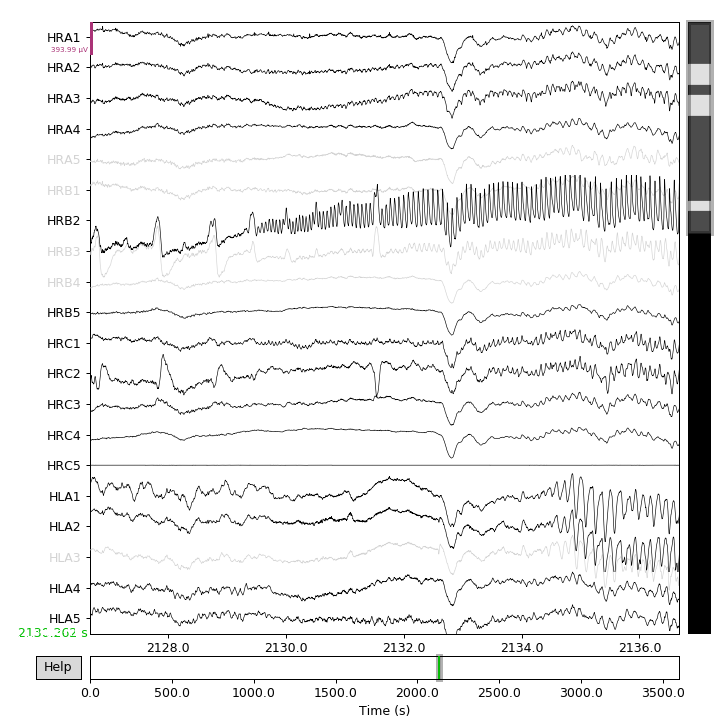

<IPython.core.display.Javascript object>


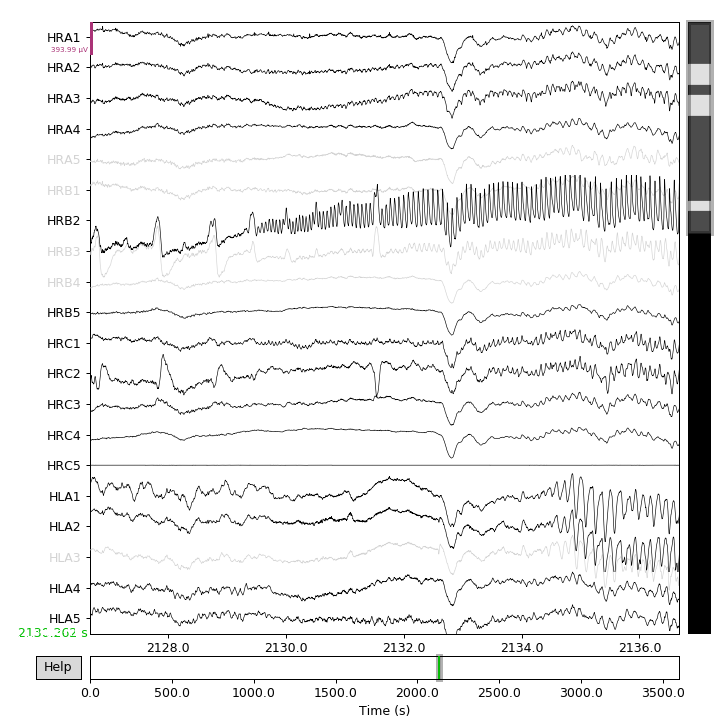

In [16]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import sklearn
import mne
from mne.time_frequency import psd_welch
import csv
import datetime
from datetime import timedelta
datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'
import re
import imblearn

from numpy.fft import fft, fftfreq
from scipy import signal
from mne.time_frequency import tfr_morlet
import mne.preprocessing
#from mne.preprocessing import annotate_amplitude

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import norm
%matplotlib notebook
mne.set_log_level('ERROR') 
#plt.ioff()
#matplotlib.use('Agg')

#path_to_data = './patient_info_txt/data_files_442.txt'
#path_to_csv = './patient_info_txt/Invasive_data_442.csv'

path_to_data = data_file_path + str(patient_id[p_id]) + '.txt'
path_to_csv = csv_file_path + str(patient_id[p_id]) + '.csv'

data_dict = {}

def square_data(inputs):
    data_df = pd.Series(inputs)
    data_df_sq = data_df.pow(2)
    data_df_np = data_df_sq.to_numpy()
    return data_df_np

def normalize_data(inputs):
    data_df_HRC1 = pd.Series(inputs)
    data_df_std_dev = data_df_HRC1.rolling(time_steps).std() # 30 seconds
    data_df_norm = data_df_HRC1.divide(data_df_std_dev)  
    data_df_norm[:time_steps-1].update(data_df_HRC1[:time_steps-1]) # if NaN, norm = original value
    data_df_HRC1_np = data_df_norm.to_numpy()
    return data_df_HRC1_np

def diff_data(inputs):  #TODO : Do this before rereferencing
    data_df = pd.Series(inputs)
    data_df_diff= data_df.diff()
    data_df_np = data_df_diff.to_numpy()
    return data_df_np

def dur(num):
    if num/60 > 1:
        return 60.0
    else:
        return float(num)

#Reref    
#HRA = ['HRA1','HRA2','HRA3','HRA4','HRA5']
#HRB = ['HRB1','HRB2','HRB3','HRB4','HRB5','HRC1','HRC2','HRC3','HRC4','HRC5']
#HRC = ['HRB1','HRB2','HRB3','HRB4','HRB5','HRC1','HRC2','HRC3','HRC4','HRC5']

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be slow')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
my_database ={'Patient 1':{'PatientID': 0, 'FileID': [], 'Frequency': 512, 'Duration': 0}}

print('HERE WE GO!!!!!!!!!!!!!!')
with open(path_to_data) as file:
    lines = file.readlines()
    lines_iter = iter(lines)
    lines = [line.rstrip() for line in lines]
    #print('lines', lines, len(lines))
            
def load_raw_dataset(line, my_database):
    """Load a recording from the iEEG dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .data file containing the raw data.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG. 
    """
    #for line in range(0,len(lines)):
    print(line, type(line))
    #if not line.startswith("#"):
    entry = 'EEG_inv_' + str(line)[-18:-15] + '_' + str(line)[-9:-5]
    print('Value for entry',entry)
    my_database['Patient 1']['PatientID'] = str(line)[-18:-15]
    my_database['Patient 1']['FileID'] = str(line)[-9:-5]
    print(my_database)
    data_raw =  mne.io.read_raw_nicolet(str(line), 'eeg', preload=True)
    
    subj_num, rec_num = int(str(line)[-18:-15]), int(str(line)[-9:-5])
    print('subj_num',subj_num ,'rec_num',rec_num)
    data_raw.info['subject_info'] = {'id': subj_num, 'rec_id': rec_num}
    return data_raw

# Check 
#load_raw_dataset(lines,my_database)
# Load recordings
data_raws = [load_raw_dataset(line, my_database) for line in lines]
print('Database entries',len(data_raws) , type(data_raws) )

#data_raws[0].plot()
#data_raws[1].plot()
data_raws[2].plot()
#data_raws[3].plot()
#for idx in range(0,len(data_raws)):
#    print(data_raws[idx].info)
#    data_raws[idx].plot()
#    break
#a, b = data_raws[0].preprocessing.annotate_amplitude(peak=1000, flat=None, bad_percent=5, 
#                                     min_duration=5, picks=patient_channels)
#experiment with annotation and artifact detection and labelling
#a, b = mne.preprocessing.annotate_amplitude(data_raws[0],peak=100, flat=None, bad_percent=5, 
#                                     min_duration=5, picks=patient_channels)
#print(a,b)


In [ ]:
#! pip install -U mne # ==0.24.1
plt.ioff()
matplotlib.use('Agg')

In [17]:
sub_clinical_file = '../EEG_SNN/patient_info_txt/subclinical/subclinical_data_' + str(patient_id[p_id]) + '.csv'
print(sub_clinical_file)
def remove_sub_clinical_s(sub_clinical_file , raw, csv_row):
    onset_sub_list = []
    dur_sub_list = []
    desc_list = []
    
    #Selectively read csv file
    df_subclinical = pd.read_csv(sub_clinical_file, usecols=['meas_date','onset', 'offset','Seizure','File'])
    
    #Generate information on number of seizures in a file
    df_file = df_subclinical.loc[df_subclinical['File'] == csv_row]
    all_meas_data = df_file.iloc[0,0]
    all_onset = df_file['onset'].tolist()
    all_offset = df_file['offset'].tolist()
    print('all_meas_data',all_meas_data, 'all_onset',all_onset, len(all_onset),'all_offset',all_offset, len(all_offset))

    if (df_file.iloc[0,3] !=0 ):
        assert(df_file.iloc[0,3] == len(all_onset) )
        assert(len(all_offset) == len(all_onset) )
        for i in range(0,len(all_offset)):
            onset_sub = datetime.datetime.strptime(all_onset[i], datetimeFormat)- datetime.datetime.strptime(all_meas_data, datetimeFormat)
            dur_sub = datetime.datetime.strptime(all_offset[i], datetimeFormat)- datetime.datetime.strptime(all_onset[i], datetimeFormat)
            desc = 'BAD_scs_' + str(i+1)
            onset_sub_list.append(onset_sub.seconds)
            dur_sub_list.append(dur_sub.seconds)
            desc_list.append(desc)
        print('There is a subclinical seizure in ', csv_row,'th file:', onset_sub_list, dur_sub_list, desc_list)
        sub_clinical_annot = mne.Annotations(onset= onset_sub_list,
                                              duration= dur_sub_list,
                                              description= desc_list)
        raw_n = raw.copy().set_annotations(sub_clinical_annot)
        #raw_n.plot()
        print('double check annotation',sub_clinical_annot)
        #print(raw_n.info)
    else:
        print('There is NO subclinical seizure in ', csv_row,'th file.')
        raw_n = raw
        #raw_n.plot()
        #print(raw_n.info)
    return raw_n

../EEG_SNN/patient_info_txt/subclinical/subclinical_data_253.csv


[2110.]
[141.]


<IPython.core.display.Javascript object>


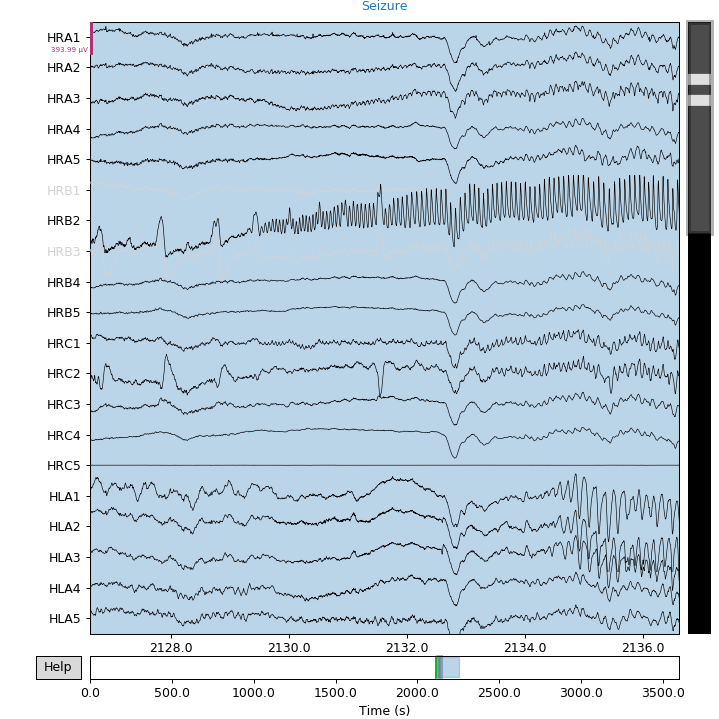

<Info | 8 non-empty values
 bads: []
 ch_names: HRA1, HRA2, HRA3, HRA4, HRA5, HRB1, HRB2, HRB3, HRB4, HRB5, ...
 chs: 58 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2004-03-24 16:20:49 UTC
 nchan: 58
 projs: []
 sfreq: 512.0 Hz
 subject_info: 2 items (dict)
>


In [19]:
#Visualize and annotate subclinical seizures
onset_subclinical = datetime.datetime.strptime('2004-03-24 16:55:59.025391', datetimeFormat)- datetime.datetime.strptime('2004-03-24 16:20:49.0', datetimeFormat)
dur_subclinical = datetime.datetime.strptime('2004-03-24 16:58:20.482422', datetimeFormat)- datetime.datetime.strptime('2004-03-24 16:55:59.025391', datetimeFormat)
later_annot = mne.Annotations(onset=[onset_subclinical.seconds],
                              duration=[dur_subclinical.seconds],
                              description=['Seizure'])

data_ch_dict_scs =  data_raws[2].copy().set_annotations(later_annot)
print(data_ch_dict_scs.annotations.onset)
print(data_ch_dict_scs.annotations.duration)
#data_ch_dict_scs = data_ch_dict_scs.pick_channels(['BLA1','BLA2','BLA3','BLA4','BLA5',
#                                                  'BLC1','BLC2','BLC3','BLC4','BLC5'
#                                                  'BRA1','BRA2','BRA3','BRA4',
#                                                   'TRA1','TRA2','TRA3','TRA4','TRA5'])
data_ch_dict_scs.plot()
print(data_ch_dict_scs.info)

[2743.]
[16.]


<IPython.core.display.Javascript object>


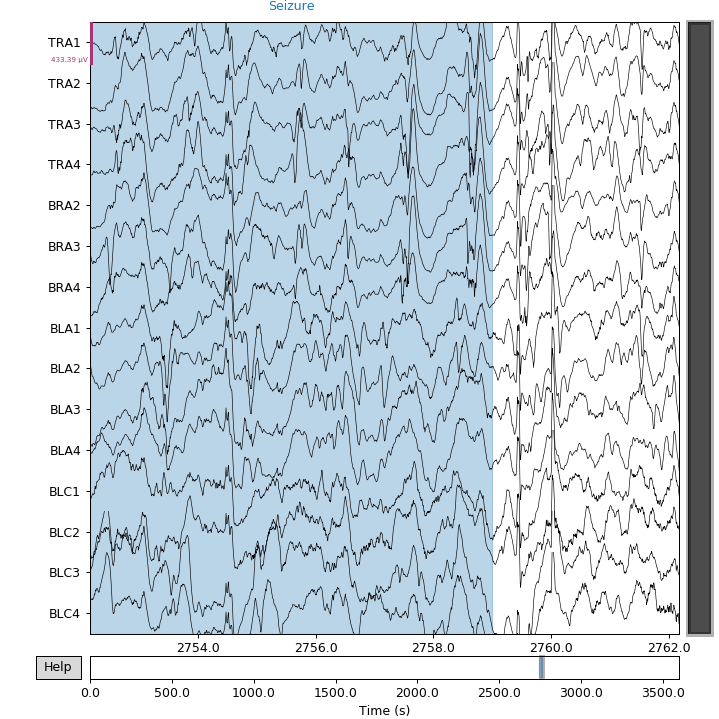

<Info | 8 non-empty values
 bads: []
 ch_names: TRA1, TRA2, TRA3, TRA4, BRA2, BRA3, BRA4, BLA1, BLA2, BLA3, ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2005-01-27 22:58:25 UTC
 nchan: 15
 projs: []
 sfreq: 256.0 Hz
 subject_info: 2 items (dict)
>


In [11]:
#Visualize and annotate subclinical seizures
onset_subclinical = datetime.datetime.strptime('2005-01-27 23:44:08.398438', datetimeFormat)- datetime.datetime.strptime('2005-01-27 22:58:25.0', datetimeFormat)
dur_subclinical = datetime.datetime.strptime('2005-01-27 23:44:25.066406', datetimeFormat)- datetime.datetime.strptime('2005-01-27 23:44:08.398438', datetimeFormat)
later_annot = mne.Annotations(onset=[onset_subclinical.seconds],
                              duration=[dur_subclinical.seconds],
                              description=['Seizure'])

data_ch_dict_scs =  data_raws[4].copy().set_annotations(later_annot)
print(data_ch_dict_scs.annotations.onset)
print(data_ch_dict_scs.annotations.duration)
data_ch_dict_scs = data_ch_dict_scs.pick_channels(['BLA1','BLA2','BLA3','BLA4','BLA5',
                                                  'BLC1','BLC2','BLC3','BLC4','BLC5'
                                                  'BRA1','BRA2','BRA3','BRA4',
                                                   'TRA1','TRA2','TRA3','TRA4','TRA5'])
data_ch_dict_scs.plot()
print(data_ch_dict_scs.info)

[3411.]
[33.]


<IPython.core.display.Javascript object>


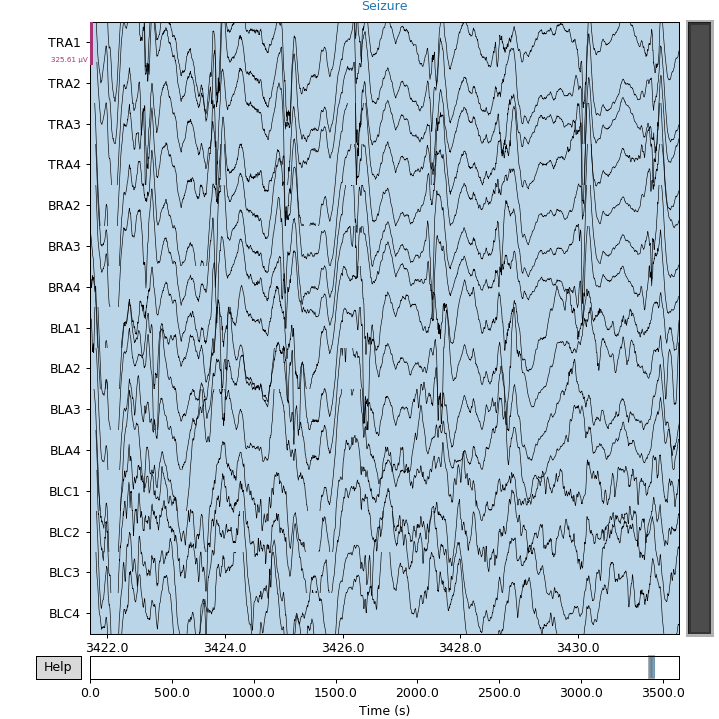

<Info | 8 non-empty values
 bads: []
 ch_names: TRA1, TRA2, TRA3, TRA4, BRA2, BRA3, BRA4, BLA1, BLA2, BLA3, ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2005-01-27 22:58:25 UTC
 nchan: 15
 projs: []
 sfreq: 256.0 Hz
 subject_info: 2 items (dict)
>


In [10]:
#Visualize and annotate subclinical seizures
onset_subclinical = datetime.datetime.strptime('2005-01-27 23:55:16.351563', datetimeFormat)- datetime.datetime.strptime('2005-01-27 22:58:25.0', datetimeFormat)
dur_subclinical = datetime.datetime.strptime('2005-01-27 23:55:50.261719', datetimeFormat)- datetime.datetime.strptime('2005-01-27 23:55:16.351563', datetimeFormat)
later_annot = mne.Annotations(onset=[onset_subclinical.seconds],
                              duration=[dur_subclinical.seconds],
                              description=['Seizure'])

data_ch_dict_scs =  data_raws[5].copy().set_annotations(later_annot)
print(data_ch_dict_scs.annotations.onset)
print(data_ch_dict_scs.annotations.duration)
data_ch_dict_scs = data_ch_dict_scs.pick_channels(['BLA1','BLA2','BLA3','BLA4','BLA5',
                                                  'BLC1','BLC2','BLC3','BLC4','BLC5'
                                                  'BRA1','BRA2','BRA3','BRA4',
                                                   'TRA1','TRA2','TRA3','TRA4','TRA5'])
data_ch_dict_scs.plot()
print(data_ch_dict_scs.info)

[285.]
[89.]


<IPython.core.display.Javascript object>


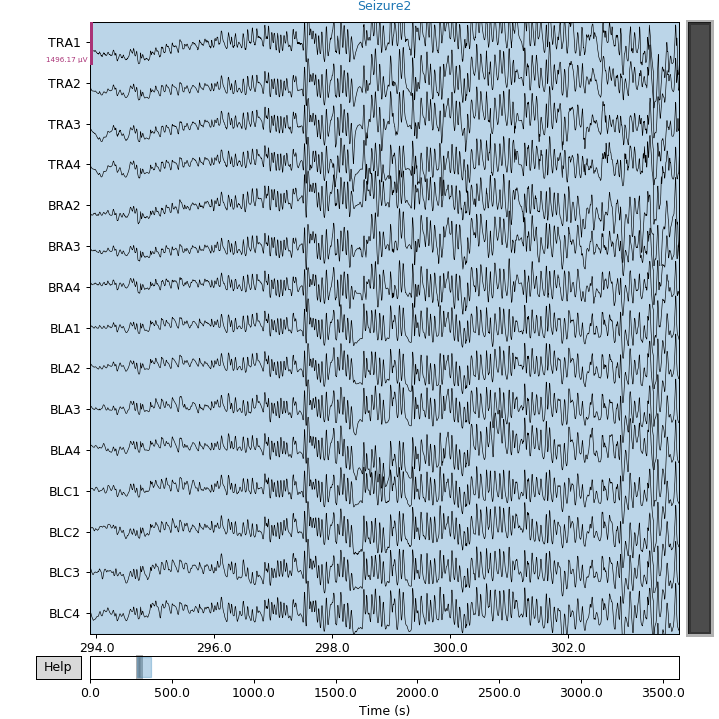

<Info | 8 non-empty values
 bads: []
 ch_names: TRA1, TRA2, TRA3, TRA4, BRA2, BRA3, BRA4, BLA1, BLA2, BLA3, ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2005-01-27 23:58:25 UTC
 nchan: 15
 projs: []
 sfreq: 256.0 Hz
 subject_info: 2 items (dict)
>


In [9]:
onset_subclinical = datetime.datetime.strptime('2005-01-28 00:03:10.425781', datetimeFormat)- datetime.datetime.strptime('2005-01-27 23:58:25.0', datetimeFormat)
dur_subclinical = datetime.datetime.strptime('2005-01-28 00:04:39.574219', datetimeFormat)- datetime.datetime.strptime('2005-01-28 00:03:10.425781', datetimeFormat)

later_annot = mne.Annotations(onset=[onset_subclinical.seconds],
                              duration=[dur_subclinical.seconds],
                              description=['Seizure2'])

data_ch_dict_scs =  data_raws[6].copy().set_annotations(later_annot)
print(data_ch_dict_scs.annotations.onset)
print(data_ch_dict_scs.annotations.duration)
data_ch_dict_scs = data_ch_dict_scs.pick_channels(['BLA1','BLA2','BLA3','BLA4','BLA5',
                                                  'BLC1','BLC2','BLC3','BLC4','BLC5'
                                                  'BRA1','BRA2','BRA3','BRA4',
                                                   'TRA1','TRA2','TRA3','TRA4','TRA5'])
data_ch_dict_scs.plot()
print(data_ch_dict_scs.info)

In [ ]:
onset_subclinical = datetime.datetime.strptime('2004-03-24 16:55:59.025391', datetimeFormat)- datetime.datetime.strptime('2004-03-24 16:20:49.0', datetimeFormat)
dur_subclinical = datetime.datetime.strptime('2004-03-24 16:58:20.482422', datetimeFormat)- datetime.datetime.strptime('2004-03-24 16:55:59.025391', datetimeFormat)


later_annot = mne.Annotations(onset=[onset_subclinical.seconds],
                              duration=[dur_subclinical.seconds],
                              description=['Seizure3'])

data_ch_dict_scs =  data_raws[2].copy().set_annotations(later_annot)
print(data_ch_dict_scs.annotations.onset)
print(data_ch_dict_scs.annotations.duration)
data_ch_dict_scs.plot()
print(data_ch_dict_scs.info)

In [ ]:
onset_subclinical = datetime.datetime.strptime('2006-10-06 10:28:07.089844', datetimeFormat)- datetime.datetime.strptime('2006-10-06 10:22:16.0', datetimeFormat)
dur_subclinical = datetime.datetime.strptime('2006-10-06 10:28:29.875000', datetimeFormat)- datetime.datetime.strptime('2006-10-06 10:28:07.089844', datetimeFormat)

later_annot = mne.Annotations(onset=[onset_subclinical.seconds],
                              duration=[dur_subclinical.seconds],
                              description=['SCS6'])

data_ch_dict_scs =  data_raws[6].copy().set_annotations(later_annot)
print(data_ch_dict_scs.annotations.onset)
print(data_ch_dict_scs.annotations.duration)
data_ch_dict_scs.plot()
print(data_ch_dict_scs.info)

In [ ]:
data_raws[2].plot(block=True)

In [ ]:
#a, b = mne.preprocessing.annotate_amplitude(data_raws[0],peak=0.00002,min_duration=0.05, picks =patient_channels)
a, b = mne.preprocessing.annotate_amplitude(data_raws[6],peak=0.00007,min_duration=0.05, picks =patient_channels)
print(a,b)
data_raws[6].set_annotations(a)  # add to existing
data_raws[6].plot()

In [ ]:
# Set reference channel for all data points for all channels individually
def set_reference(data_raw, p_id):
    data_array = []
    sfreq = data_raw.info['sfreq']
    print('sfreq', sfreq)
    print('4 electrodes for the patient',soz_channel_list[patient_id[p_id]])
    patient_channels = soz_channel_list[patient_id[p_id]]
    print('patient channels',patient_channels)
    all_channels = data_raw.ch_names
    #print('all channels',all_channels)
    for item in patient_channels:
        #print('For channel', item)
        ch_group = " ".join(re.findall("[a-zA-Z]+", item))
        ch_group = str(ch_group)
        ch_group = [x for x in all_channels if re.search(ch_group, x)]
        #print('Electrode group', str(ch_group))
        data_ch_dict = data_raw.copy()
        data_ch_dict = data_ch_dict.pick_channels(ch_names= ch_group, ordered=False)
        data_ch_dict.set_eeg_reference(ref_channels= ch_group)
        data_ch_dict = data_ch_dict.pick_channels(ch_names= [item], ordered=False)
        df_channel = data_ch_dict.to_data_frame()
        #print('Each channel', df_channel)
        #print('Info', data_ch_dict.info)
        df_channel_array = np.array(df_channel[item])
        #print(df_channel_array, df_channel_array.shape)
        data_array.append(df_channel_array)
        
    reref_data = np.array(data_array)
    print('reref data', reref_data, reref_data.shape)
    info = mne.create_info(ch_names= patient_channels, sfreq=sfreq, ch_types = ['eeg']* 4)
    print('Assert',len(reref_data), len(info['ch_names']), patient_channels)
    simulated_raw = mne.io.RawArray(reref_data, info)
    #print(simulated_raw.info)
    return simulated_raw 

reref_raws = []
for idx in range(0,len(data_raws)):
    #print('BEFORE RE-REFERENCING',data_raws[idx].info)
    #data_raws[idx].plot()
    reref_raws.append(set_reference(data_raws[idx],p_id))
    #reref_raws[idx] = set_reference(data_raws[idx],2)
    #print('AFTER RE-REFERENCING',reref_raws[idx].info)
    #reref_raws[idx].plot()
    #break

print(reref_raws)

In [ ]:
def create_epochs(data_ch_dict, start, end, interval, csv_row): #REJECT ANNOTATION with no overlap
    #Create epochs separately
    if end < 3599.9961:
        data_ch_dict_bf = data_ch_dict.copy().crop(tmin=0, tmax=start)
        data_epoch_bf =  mne.make_fixed_length_epochs(data_ch_dict_bf, duration= interval, preload=True ,reject_by_annotation=True, id= csv_row)
        data_ch_dict_sz = data_ch_dict.copy().crop(tmin=start, tmax=end)
        data_epoch_sz = mne.make_fixed_length_epochs(data_ch_dict_sz, duration= interval, preload=True, id= csv_row)
        data_ch_dict_af = data_ch_dict.copy().crop(tmin=end)
        data_epoch_af = mne.make_fixed_length_epochs(data_ch_dict_af, duration= interval, preload=True, reject_by_annotation=True,  id= csv_row)
        print('length of all epochs', len(data_epoch_bf), len(data_epoch_sz), len(data_epoch_af))
        return data_epoch_bf, data_epoch_sz, data_epoch_af
    else:
        end = 3599.0
        print('Hey', start, end)
        data_ch_dict_bf = data_ch_dict.copy().crop(tmin=0, tmax=start)
        data_epoch_bf =  mne.make_fixed_length_epochs(data_ch_dict_bf, duration= interval, preload=True, reject_by_annotation=True, id= csv_row)
        data_ch_dict_sz = data_ch_dict.copy().crop(tmin=start, tmax=end)
        data_epoch_sz = mne.make_fixed_length_epochs(data_ch_dict_sz, duration= interval, preload=True, id= csv_row)
        data_epoch_af = data_epoch_bf[0]
        print('length of all epochs', len(data_epoch_bf), len(data_epoch_sz), len(data_epoch_af))
        return data_epoch_bf, data_epoch_sz, data_epoch_af

In [ ]:
def create_epochs(data_ch_dict, start, end, interval, csv_row): #REJECT ANNOTATION with 0.1 second overlap
    #Create epochs separately
    if end < 3599.9961:
        data_ch_dict_bf = data_ch_dict.copy().crop(tmin=0, tmax=start)
        data_epoch_bf =  mne.make_fixed_length_epochs(data_ch_dict_bf, duration= interval, preload=True ,reject_by_annotation=True, id= csv_row)
        data_ch_dict_sz = data_ch_dict.copy().crop(tmin=start, tmax=end)
        data_epoch_sz = mne.make_fixed_length_epochs(data_ch_dict_sz, duration= interval, preload=True, 
                                                             overlap = float(interval -1) + 0.75, id= csv_row)
        data_ch_dict_af = data_ch_dict.copy().crop(tmin=end)
        data_epoch_af = mne.make_fixed_length_epochs(data_ch_dict_af, duration= interval, preload=True, reject_by_annotation=True,  id= csv_row)
        print('length of all epochs', len(data_epoch_bf), len(data_epoch_sz), len(data_epoch_af))
        return data_epoch_bf, data_epoch_sz, data_epoch_af
    else:
        end = 3599.0
        print('Hey', start, end)
        data_ch_dict_bf = data_ch_dict.copy().crop(tmin=0, tmax=start)
        data_epoch_bf =  mne.make_fixed_length_epochs(data_ch_dict_bf, duration= interval, preload=True, reject_by_annotation=True, id= csv_row)
        data_ch_dict_sz = data_ch_dict.copy().crop(tmin=start, tmax=end)
        data_epoch_sz = mne.make_fixed_length_epochs(data_ch_dict_sz, duration= interval, preload=True, 
                                                             overlap = float(interval -1) + 0.75, id= csv_row)
        data_epoch_af = data_epoch_bf[0]
        print('length of all epochs', len(data_epoch_bf), len(data_epoch_sz), len(data_epoch_af))
        return data_epoch_bf, data_epoch_sz, data_epoch_af

In [ ]:
def create_epochs(data_ch_dict, start, end, interval, csv_row):
    #Create epochs separately
    if end < 3599.9961:
        data_ch_dict_bf = data_ch_dict.copy().crop(tmin=0, tmax=start)
        data_epoch_bf =  mne.make_fixed_length_epochs(data_ch_dict_bf, duration= interval, preload=True,id= csv_row)
        data_ch_dict_sz = data_ch_dict.copy().crop(tmin=start, tmax=end)
        data_epoch_sz = mne.make_fixed_length_epochs(data_ch_dict_sz, duration= interval, preload=True, 
                                                             overlap = float(interval -1), id= csv_row)
        data_ch_dict_af = data_ch_dict.copy().crop(tmin=end)
        data_epoch_af = mne.make_fixed_length_epochs(data_ch_dict_af, duration= interval, preload=True, id= csv_row)
        print('length of all epochs', len(data_epoch_bf), len(data_epoch_sz), len(data_epoch_af))
        return data_epoch_bf, data_epoch_sz, data_epoch_af
    else:
        end = 3599.0
        print('Hey', start, end)
        data_ch_dict_bf = data_ch_dict.copy().crop(tmin=0, tmax=start)
        data_epoch_bf =  mne.make_fixed_length_epochs(data_ch_dict_bf, duration= interval, preload=True, id= csv_row)
        data_ch_dict_sz = data_ch_dict.copy().crop(tmin=start, tmax=end)
        data_epoch_sz = mne.make_fixed_length_epochs(data_ch_dict_sz, duration= interval, preload=True, 
                                                             overlap = float(interval -1), id= csv_row)
        data_epoch_af = data_epoch_bf[0]
        print('length of all epochs', len(data_epoch_bf), len(data_epoch_sz), len(data_epoch_af))
        return data_epoch_bf, data_epoch_sz, data_epoch_af

In [ ]:
def artifact_rejection_threshold(data_ch_dict):
    df_ptp = data_ch_dict.to_data_frame(scalings=dict(eeg=1)) 
    ch1_values = np.absolute(df_ptp[patient_channels[0]].to_numpy())
    sorted_index_ch1_values = np.argsort(ch1_values)
    sorted_ch1_values = ch1_values[sorted_index_ch1_values]
    n1 = int(ch1_values.size*0.05)
    rslt1 = sorted_ch1_values[-n1 : ]
    print('Sorted top 5 percent channel 1',rslt1, n1)
    
    ch2_values = np.absolute(df_ptp[patient_channels[1]].to_numpy())
    sorted_index_ch2_values = np.argsort(ch2_values)
    sorted_ch2_values = ch2_values[sorted_index_ch2_values]
    n2 = int(ch2_values.size*0.05)
    rslt2 = sorted_ch2_values[-n2 : ]
    print('Sorted top 5 percent channel 2',rslt2, n2)
    
    ch3_values = np.absolute(df_ptp[patient_channels[2]].to_numpy())
    sorted_index_ch3_values = np.argsort(ch3_values)
    sorted_ch3_values = ch3_values[sorted_index_ch3_values]
    n3 = int(ch3_values.size*0.05)
    rslt3 = sorted_ch3_values[-n3 : ]
    print('Sorted top 5 percent channel 3',rslt3, n3)
    
    ch4_values = np.absolute(df_ptp[patient_channels[3]].to_numpy())
    sorted_index_ch4_values = np.argsort(ch4_values)
    sorted_ch4_values = ch4_values[sorted_index_ch4_values]
    n4 = int(ch4_values.size*0.05)
    rslt4 = sorted_ch4_values[-n4 : ]
    print('Sorted top 5 percent channel 4',rslt4, n4)
    
    #Concatenate and get top 0.1%
    concat_vals = np.concatenate((rslt1, rslt2, rslt3, rslt4))
    sorted_index_array_all = np.argsort(concat_vals)
    sorted_array_all = concat_vals[sorted_index_array_all]
    n_all = int(concat_vals.size*0.001)
    rslt_all = sorted_array_all[-n_all : ]
    print('Sorted top .1 percent from all channels',rslt_all, n_all)
    threshold_val = int(rslt_all[0])
    print('Thresholding', threshold_val)
    return threshold_val

In [ ]:
def dt_(t_sample, meas_data):
    #time = float(datetime.datetime.strptime(t_sample, datetimeFormat))
    time = float((datetime.datetime.strptime(t_sample, datetimeFormat)- 
                 datetime.datetime.strptime(meas_data, datetimeFormat)).seconds)
    return time

def process_file(data_raw, csv_row, interval , test_dir):
    df = pd.read_csv(path_to_csv, usecols=['meas_date','onset', 'offset','onset_sample','offset_sample', 'channels'])
    cnt_data =0
    cnt_data_ch = 0
    columns_ = []
    meas_date = []
    seizure_count = []
    data_ch_dict = [None] * len(data_raw)
    data_epoch = [None] * len(data_raw)
    #print('len of data_raw', len(data_raw))
    
    #Generate information on number of seizures in a file
    all_meas_data = df.iloc[:,0]
    all_onset = df.iloc[:,1]
    all_offset = df.iloc[:,2]
    all_onset_sample = df.iloc[:,3]
    all_offset_sample = df.iloc[:,4]
    meas_date = all_meas_data.tolist()
    onset_date = all_onset.tolist()
    offset_date = all_offset.tolist()
    onset_sample_date = all_onset_sample.tolist()
    offset_sample_date = all_offset_sample.tolist()
    for i in range(0,len(meas_date)):
        if i==0:
            seiz = 1 ; cnt =1
        else:
            if (meas_date[i-1] == meas_date[i]):
                cnt +=1 ; seiz = cnt
            else:
                seiz = 1 ; cnt =1
        seizure_count.append(seiz)
    #print('Seizure count list',seizure_count, len(seizure_count), csv_row)
    
    num_of_seizure_in_file = [1] * len(seizure_count)
    for i in range(0,len(seizure_count)): 
        if seizure_count[i] == 2:
            num_of_seizure_in_file[i] = 2
            num_of_seizure_in_file[i-1] = 2
        if seizure_count[i] == 3:
            num_of_seizure_in_file[i] = 3
            num_of_seizure_in_file[i-1] = 3
            num_of_seizure_in_file[i-2] = 3
    #print('num of seizures from a file',num_of_seizure_in_file)
    
    #print("seizure starts after:",tdiff_on, "seizure lasts for",tdur_seiz,"stops after",tdiff_off)
    #print('Seizure onset',onset,'Seizure offset',offset )
    #print(print("seizure starts after:",tdiff_on.seconds, "seizure lasts for",tdur_seiz.seconds,"stops after",tdiff_off.seconds))

    '''
    for arr in range(len(channel)):
        for lis in range(len(channel[arr])):
            channel[arr][lis].replace('\'','')
            channel[arr][lis].replace(']','')
            channel[arr][lis].replace('[','')
            channel[arr][lis].replace(' ','')
    #print("Shape and type of tdiff_on:",type(tdiff_on),tdiff_on, 'channel',channel)
    
    if channel.find(',') != -1:
        channel = list(channel.split(","))
        #rint('HEY FOUND A ,', channel,len(channel), type(channel))
    else:
        channel = list(channel.split(","))
        #print('HEY DID NOT FIND ,', channel, len(channel), type(channel))
    '''
    cnt_data += 1
    
    #Signal prepreocessing
    #print('measurement data',meas_data, meas_data_next)
    
    #ch_name = entry 
    #ref_ch = HRB
    #ref_ch = data_raw.ch_names

    data_ch_dict = data_raw.copy()
    #print('Before re-referencing',data_ch_dict.info)
    #data_ch_dict.plot()
    #data_ch_dict = data_ch_dict.pick_channels(ch_names= ref_ch, ordered=False)
    #data_ch_dict.set_eeg_reference(ref_channels=ref_ch) #TODO add rereferencing
    #print('After re-referencing',data_ch_dict.info)
    #data_ch_dict.plot()
    
    #Annotate subclinical seizures
    data_ch_dict = remove_sub_clinical_s(sub_clinical_file ,data_ch_dict, csv_row)
    
    #Resampling and anti-aliasing low pass filter
    data_ch_dict.load_data().filter(l_freq=None, h_freq=90, method='fir',picks=patient_channels) #lafa 90
    #print('AFTER ANTI ALISAING FILTER')
    #data_ch_dict.plot_psd(picks=patient_channels)
    if data_ch_dict.info['sfreq'] != 256.0:
        data_ch_dict = data_ch_dict.resample(256)
    #data_ch_dict.plot()
    
    #print('After resampling',data_ch_dict.info)
    data_ch_dict.load_data().filter(l_freq=0.2, h_freq=48, method='fir',picks=patient_channels) #lafa 48
    print('After filtering',data_ch_dict.info)
    #print('AFTER BPF')
    data_ch_dict.plot_psd(picks=patient_channels)
    
    #Notch filter for lafa
    #data_ch_dict.notch_filter(50)  #lafa remove
    
    do_normalization = False
    calculate_dt= False
    #time_steps = (10*60)/2
    time_steps = 10
    
    #Calculate time difference     #before re-referencing TODO
    if calculate_dt == True:
        #print('First derivative', channel)
        data_ch_dict.apply_function(diff_data, picks=channel)
        #print('After first derivative',data_ch_dict.info)
        #data_ch_dict.plot()
    else:
        data_ch_dict = data_ch_dict
        #print('First derivative not taken')
    
    # TODO ; Temporary use HRB2 and HRC2
    #channel_temp = ['HRB2','HRC2', 'HRB3','HRC3']
    #channel_temp = ['HRB2','HRC2']
    #channel_temp = ['TLB1', 'TLA1', 'HL1', 'TBA1']
    #channel_temp = ['HRA4', 'TBA1', 'HRA5', 'TBA2']
    #data_ch_dict.pick_channels(ch_names = channel_temp, ordered = False)
    #print(data_ch_dict.info)
    
    #seizure starts after: 17 seizure lasts for 55 stops after 73
    #print(print("seizure starts after:",tdiff_on.seconds, "seizure lasts for",tdur_seiz.seconds,"stops after",tdiff_off.seconds))
    #print(print("seizure starts after:",tdiff_on.microseconds, "seizure lasts for",tdur_seiz.microseconds,"stops after",tdiff_off.microseconds))
    #seizure starts after: 0:00:17.558594 seizure lasts for 0:00:55.945312 stops after 0:01:13.503906
    #data_ch_dict.plot()
    
    #Generate labels
    for col in range(0,len(df.columns)):
        data = df.iloc[csv_row,col]
        columns_.append(data)
    
    meas_data = columns_[0]
    onset = columns_[1]
    offset = columns_[2]
    onset_sample = columns_[3]
    offset_sample = columns_[4]
    channel = columns_[5]

    tdur_seiz = datetime.datetime.strptime(offset, datetimeFormat)- datetime.datetime.strptime(onset, datetimeFormat)
    tdiff_on = datetime.datetime.strptime(onset, datetimeFormat)- datetime.datetime.strptime(meas_data, datetimeFormat)
    tdiff_off = datetime.datetime.strptime(offset, datetimeFormat)- datetime.datetime.strptime(meas_data, datetimeFormat)

    #print('measurement',meas_data, datetime.datetime.strptime(meas_data, datetimeFormat))
    #print('onset',onset, datetime.datetime.strptime(onset, datetimeFormat))
    #print('offset',offset, datetime.datetime.strptime(offset, datetimeFormat))
    print('tdiff_on',float(tdiff_on.seconds) ,'tdiff_off',float(tdiff_off.seconds) ,'tdur_seiz',float(tdur_seiz.seconds)  )
    print('tdiff_on',tdiff_on ,'tdiff_off',tdiff_off ,'tdur_seiz',tdur_seiz )
    '''
    if (csv_row == len(seizure_count)-1):
        print('This file has ',seizure_count[csv_row],'seizures')
        
    elif(csv_row == len(seizure_count)-2):
        if(seizure_count[csv_row] == 1 and seizure_count[csv_row+1] == 2 ):
            print('This file has 2 seizures')
        elif(seizure_count[csv_row] == 2 and seizure_count[csv_row+1] == 3 ):
            print('This file has 3 seizures')
        else:
            print('This file has 1 seizure')
        
    elif ((seizure_count[csv_row] == 1) and (seizure_count[csv_row+1] ==1)):
        print('This file has only one seizure')
    
    elif(((seizure_count[csv_row] == 1) and (seizure_count[csv_row+1] ==2) and (seizure_count[csv_row+2] ==1)) or ((seizure_count[csv_row] ==2) and (seizure_count[csv_row+1] ==1))):
        print('This file has 2 seizures')
    
    elif(((seizure_count[csv_row] == 1) and (seizure_count[csv_row+1] ==2) and (seizure_count[csv_row+2] ==3)) or ((seizure_count[csv_row] == 2) and (seizure_count[csv_row+1] ==3)) or (seizure_count[csv_row] == 3)):
        print('This file has 3 seizures')'''
    
    #Extract 5s epochs : Create epochs and labels
    interval = interval  #TODO 2 sec
    time_window = interval * data_ch_dict.info['sfreq'] # 5*512
    #print('time window', time_window)
    
    #Split
    if (num_of_seizure_in_file[csv_row] == 1):
        data_ch_dict = data_ch_dict.copy()
        print('data_ch_dict_1',data_ch_dict)
        df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
        df['time_s'] = df['time'] / 1000.0
        df['target'] = 0
        df['target'] = np.where(((df.time_s >= float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1 ,df.target)        
        seizure_length = float(tdiff_off.seconds) - float(tdiff_on.seconds)
        print('Length of seizure is', seizure_length, 'seconds' )
        print('Check where to split epochs',float(tdiff_on.seconds), float(tdiff_off.seconds) )
            
        #Create epochs separately
        data_epoch_bf,data_epoch_sz,data_epoch_af= create_epochs(data_ch_dict, tdiff_on.seconds, tdiff_off.seconds, interval, csv_row)
            
    elif (num_of_seizure_in_file[csv_row] == 2):
        if (seizure_count[csv_row] ==1):
            split_1 = dt_(offset_date[csv_row],meas_date[csv_row])  +((dt_(onset_date[csv_row+1],meas_date[csv_row]) - dt_(offset_date[csv_row],meas_date[csv_row]))/2 )
            data_ch_dict_2_1 = data_ch_dict.copy().crop(tmin = 0, tmax = split_1)
            data_ch_dict = data_ch_dict_2_1.copy()
            print('data_ch_dict_2_1',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >=float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1,df.target)
            print('2_1', split_1,float(tdiff_on.seconds), float(tdiff_off.seconds))
            seizure_length = float(tdiff_off.seconds) - float(tdiff_on.seconds)
            print('Length of seizure is', seizure_length, 'seconds' )
            print('Check where to split epochs',float(tdiff_on.seconds), float(tdiff_off.seconds) )
            
            #Create epochs separately
            data_epoch_bf,data_epoch_sz,data_epoch_af= create_epochs(data_ch_dict, tdiff_on.seconds, tdiff_off.seconds, interval, csv_row)
            
        if (seizure_count[csv_row] ==2):
            split_1 = dt_(offset_date[csv_row-1],meas_date[csv_row])  +((dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2 )
            start = (dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2
            end = start + (dt_(offset_date[csv_row],meas_date[csv_row]) - dt_(onset_date[csv_row],meas_date[csv_row]))
            data_ch_dict_2_2 = data_ch_dict.copy().crop(tmin= split_1)
            data_ch_dict = data_ch_dict_2_2.copy()
            print('data_ch_dict_2_2',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= start) & (df.time_s <= end)),1,df.target)
            print('2_2', split_1, start, end)
            seizure_length = end - start
            print('Length of seizure is', seizure_length, 'seconds' )
            print('Check where to split epochs', start, end )
            
            #Create epochs separately
            data_epoch_bf,data_epoch_sz,data_epoch_af= create_epochs(data_ch_dict, start, end, interval, csv_row)
            
    elif (num_of_seizure_in_file[csv_row] == 3):
        if ( seizure_count[csv_row] ==1):
            split_2 = dt_(offset_date[csv_row],meas_date[csv_row])  +((dt_(onset_date[csv_row+1],meas_date[csv_row]) - dt_(offset_date[csv_row],meas_date[csv_row]))/2 )
            data_ch_dict_3_1 = data_ch_dict.copy().crop(tmin=0 ,tmax= split_2)
            data_ch_dict = data_ch_dict_3_1.copy()
            print('data_ch_dict_3_1',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1,df.target)
            print('3_1', split_2, float(tdiff_on.seconds), float(tdiff_off.seconds))
            seizure_length = float(tdiff_off.seconds) - float(tdiff_on.seconds)
            print('Length of seizure is', seizure_length, 'seconds' )
            print('Check where to split epochs', float(tdiff_on.seconds), float(tdiff_off.seconds) )

            #Create epochs separately
            data_epoch_bf,data_epoch_sz,data_epoch_af= create_epochs(data_ch_dict, tdiff_on.seconds, tdiff_off.seconds, interval, csv_row)
            
        if ( seizure_count[csv_row] ==2):
            split_2 = dt_(offset_date[csv_row-1],meas_date[csv_row])  +((dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2 )
            split_3 = dt_(offset_date[csv_row],meas_date[csv_row])  +((dt_(onset_date[csv_row+1],meas_date[csv_row]) - dt_(offset_date[csv_row],meas_date[csv_row]))/2 )
            start = (dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2
            end = start + (dt_(offset_date[csv_row],meas_date[csv_row]) - dt_(onset_date[csv_row],meas_date[csv_row])) 
            data_ch_dict_3_2 = data_ch_dict.copy().crop(tmin=split_2 ,tmax=split_3)
            data_ch_dict = data_ch_dict_3_2.copy()
            print('data_ch_dict_3_2',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= start) & (df.time_s <= end)),1,df.target)
            print('3_2', split_2, split_3, start, end)
            seizure_length = end - start
            print('Length of seizure is', seizure_length, 'seconds' )
            print('Check where to split epochs', start, end )
            
            #Create epochs separately
            data_epoch_bf,data_epoch_sz,data_epoch_af= create_epochs(data_ch_dict, start, end, interval, csv_row)
            
        if ( seizure_count[csv_row]==3):
            split_3 = dt_(offset_date[csv_row-1],meas_date[csv_row])  +((dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2 )
            start = (dt_(onset_date[csv_row],meas_date[csv_row]) - dt_(offset_date[csv_row-1],meas_date[csv_row]))/2
            end = start + (dt_(offset_date[csv_row],meas_date[csv_row]) - dt_(onset_date[csv_row],meas_date[csv_row]))
            data_ch_dict_3_3 = data_ch_dict.copy().crop(tmin=split_3 )
            data_ch_dict = data_ch_dict_3_3.copy()
            print('data_ch_dict_3_3',data_ch_dict)
            df = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
            df['time_s'] = df['time'] / 1000.0
            df['target'] = 0
            df['target'] = np.where(((df.time_s >= start) & (df.time_s <= end)),1,df.target)
            print('3_3', split_3, start, end)
            seizure_length = end - start
            print('Length of seizure is', seizure_length, 'seconds' )
            print('Check where to split epochs', start, end )
            
            #Create epochs separately
            data_epoch_bf,data_epoch_sz,data_epoch_af= create_epochs(data_ch_dict, start, end, interval, csv_row)
    
     # Store data, time and label as dataframe
    #df = data_ch_dict.to_data_frame()
    #print(df)
    #df['time_s'] = df['time'] / 1000.0
    #df['target'] = 0
    #df['target'] = np.where(((df.time_s >= float(tdiff_on.seconds)) & (df.time_s <= float(tdiff_off.seconds))),1,df.target)
    #print(df) 

    # Check the average value for high PTP thresholding - Gaussian distribution of 4 channels
    ''' 
    def gaussian(x, mu, sig):
        print('y-axis', np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
    df_ptp = data_ch_dict.to_data_frame(scalings=dict(eeg=1))
    #boxplot = df_ptp.boxplot(column=patient_channels)  
    ch1_values = np.absolute(df_ptp[patient_channels[0]].to_numpy())
    ch2_values = np.absolute(df_ptp[patient_channels[1]].to_numpy())
    ch3_values = np.absolute(df_ptp[patient_channels[2]].to_numpy())
    ch4_values = np.absolute(df_ptp[patient_channels[3]].to_numpy())
    
    #val_list = [ch1_values, ch2_values, ch3_values, ch4_values]
    val_list = [ch1_values]
    for ch_val in range(len(val_list)):
        mu = round( np.mean(val_list[ch_val]),3)
        sig = round( np.std(val_list[ch_val]),3)
        normRandVar = norm(mu, sig)
        print(mu,sig)
        label_p = 'μ: ' + str(mu)+  ', σ:' + str(sig)
        plt.plot(val_list[ch_val], normRandVar.pdf(val_list[ch_val]))
        plt.axvline(x =5*sig)
        plt.plot(val_list[ch_val], gaussian(val_list[ch_val], mu, sig),label=label_p)
        plt.xlim([-1500, 1500])
        plt.xlabel('Std Dev of amplitude in microVolt')
        plt.legend(loc=2, prop={'size': 6})
    plt.show();  #'''
    
    '''
    #Crop the data to include less non-ictal activity : Temporary logic
    def define_df(data_ch_dict, idx):
        df1 = data_ch_dict.to_data_frame()
        df1['time_s'] = df1['time'] / 1000.0
        df1['target'] = 0
        df1['target'] = np.where(( (df1.time_s+ idx >= float(tdiff_on.seconds)) & (df1.time_s + idx <= float(tdiff_off.seconds))),1,df1.target)
        return df1
    if (tdiff_on.seconds < 1200):
        data_ch_dict_n = data_ch_dict.copy().crop(tmin=0,tmax=1200) #0,1200
        print('Seizure occurs in first half')
        df_subset = define_df(data_ch_dict_n, 0)
    elif (tdiff_on.seconds > 2400):
        data_ch_dict_n = data_ch_dict.copy().crop(tmin=2400, tmax =3599) # 2400,3600
        print('Seizure occurs in end')
        df_subset = define_df(data_ch_dict_n, 2400)
    else:
        data_ch_dict_n = data_ch_dict.copy().crop(tmin=1200,tmax=2400) # 1200,2400
        print('Seizure occurs in mid ')
        df_subset = define_df(data_ch_dict_n, 1200)
       #'''    
    
    #data_epoch = mne.make_fixed_length_epochs(data_ch_dict, duration= interval, preload=True, id= csv_row) 
    #print('length of epochs before', len(data_epoch))
    #data_epoch = mne.make_fixed_length_epochs(data_ch_dict_n, duration= interval, preload=True, id= csv_row)
    #print('Fixed Length Epochs',csv_row,data_epoch, len(data_epoch), type(data_epoch) )
    #stronger_reject_criteria = dict(eeg=1000e-6)        #10microV
    #data_epoch.drop_bad(reject=stronger_reject_criteria)
    #print(data_epoch.drop_log)
    #print('Epochs return value',data_epoch.get_data(), np.shape(data_epoch.get_data()), type(data_epoch.get_data()) )
    
    #drop bad epochs
    #Reject epochs based on maximum peak-to-peak signal amplitude (PTP)
    # i.e. the absolute difference between the lowest and the highest signal value in an epoch
    
    #print('data epoch before removing artifact', data_epoch[0].to_data_frame(scalings=dict(eeg=1))['HRB2'])
    #a, b = mne.preprocessing.annotate_amplitude(data_ch_dict,peak=500.0, flat=None, bad_percent=5.0, 
    #                                 min_duration=5.0, picks=patient_channels, verbose=2)
    #print(a,b)

    ##stronger_reject_criteria = dict(eeg=1000)       
    ##data_epoch.drop_bad(reject=stronger_reject_criteria)
    ##print(data_epoch.drop_log)
    ##print('Dropping epochs with artifacts',len(data_epoch.drop_log), len(data_epoch))
    #print('data epoch after removing artifact', data_epoch.to_data_frame(scalings=dict(eeg=1)))
    ##df_drop= data_epoch.to_data_frame(scalings=dict(eeg=1))
    ##print(df_drop)
    #df_drop.to_csv('./temp.csv')
    
    freqs = np.logspace(*np.log10([2, 50]), num=50) #lafa 50, 50
    #freqs = np.linspace(2,98, num=90)   #lafa
    #freqs =  np.arange(5, 50, 5)
    #freqs = list(range(2, 45,2))
    #freqs = np.linspace(2, 45, 20, endpoint=True)  # TW = 2s FR = 1/2 = 0.5 HS
    #print('freqs',freqs)
    tfr_target = {}
    avgpower_ = {}
    #n_cycles = 2 #freqs / 2.
    n_cycles = [x / 2. for x in freqs]
    #n_cycles = freqs
    #print('n_cycles',n_cycles)
    decim =3
    count_temp =0
    #vmin, vmax = -0.00000003, 0.00000003
    vmin, vmax = -80000, 80000   #-2000, 2000   # lafa 
    #vmin, vmax = -80, 80
    #time_bandwidth = 2.0 

    if do_normalization == True:
        dir_name_nc = './non_ictal_std/'
        dir_name_ic = './ictal_std/'
    else:
        dir_name_nc = './TF_plot_images_temp/' + pat_id  + '/non_ictal/'
        dir_name_ic = './TF_plot_images_temp/' + pat_id  + '/ictal/'
    '''
    for ch in range(0,len(patient_channel_ids)):
        for ev in range(0, len(data_epoch)-700):
            print('Seizure got divides into',len(data_epoch),'parts')
            #tfr_target_sz[entry] = tfr_morlet(Epochs_sz[entry][ev],freqs=freqs,n_cycles=n_cycles,use_fft=True,return_itc=False, decim=decim, n_jobs=1)
            tfr_target[patient_channel_ids[ch]] = tfr_morlet(data_epoch[ev],freqs = freqs, n_cycles = n_cycles,return_itc=False,average = False, use_fft = True,decim =3, output ='power')
            #tfr_target_sz[entry].apply_baseline(mode='mean', baseline=(None, None))
            tfr_target[patient_channel_ids[ch]].apply_baseline(mode='mean', baseline=(0., 0.1)) # TODO Select baseline -1.0, 1.0
            #print(tfr_target_sz[entry].info)
            #print('Plot for this channel', data_ch_dict_list[ch_sub])
            avgpower_[patient_channel_ids[ch]] = tfr_target[patient_channel_ids[ch]].average()
            print('avg power', avgpower_)
            fig_a = avgpower_[patient_channel_ids[ch]].plot(patient_channels[ch], 
                                vmin = vmin,vmax=vmax,
                                cmap=plt.cm.RdBu_r ,
                                title = str(patient_channel_ids[ch])+ '_' + str(ev),show=False)
            fig_a[0].savefig(dir_name_ic + str(patient_channel_ids[ch])+ '_' +  str(ev)  +'.png')
            #break'''
    
    def create_plot(data_epoch,label, ev, save_dir, cntr ):
        for ch in range(0,len(patient_channel_ids)):
            #print('Seizure got divides into',len(data_epoch),'parts')
            #tfr_target_sz[entry] = tfr_morlet(Epochs_sz[entry][ev],freqs=freqs,n_cycles=n_cycles,use_fft=True,return_itc=False, decim=decim, n_jobs=1)
            tfr_target[patient_channel_ids[ch]] = tfr_morlet(data_epoch[ev],freqs = freqs, n_cycles = n_cycles,return_itc=False,average = False, use_fft = True,decim =3, output ='power')
            #tfr_target_sz[entry].apply_baseline(mode='mean', baseline=(None, None))
            tfr_target[patient_channel_ids[ch]].apply_baseline(mode='mean', baseline=(0., 0.1)) # TODO Select baseline -1.0, 1.0
            #print(tfr_target_sz[entry].info)
            #print('Plot for this channel', data_ch_dict_list[ch_sub])
            avgpower_[patient_channel_ids[ch]] = tfr_target[patient_channel_ids[ch]].average()
            #print('avg power', avgpower_[patient_channel_ids[ch]])
            fig_a = avgpower_[patient_channel_ids[ch]].plot(patient_channels[ch], 
                                vmin = vmin,vmax=vmax,
                                cmap=plt.cm.RdBu_r ,
                                #dB = True,
                                title = str(patient_channel_ids[ch])+ '_sNo_' + str(csv_row) + '_' +  str(ev+cntr) + '_' + str(label),show=False)
            fig_a[0].savefig(save_dir + str(patient_channel_ids[ch])+ '_sNo_' + str(csv_row) + '_' +  str(ev+cntr) + '_' + str(label) + '.png')
            # To get the values of time, frequency and power
            #df_pwr = avgpower_[patient_channel_ids[ch]].to_data_frame()
            #print('df_pwr', df_pwr)
    
    #New logic for image generation with dropping bad epochs!
    rejection_th = artifact_rejection_threshold(data_ch_dict)
    for i in range(rejection_th, rejection_th+1000,100):
        print('Chosen threshold', i)
        stronger_reject_criteria = dict(eeg=i)   
        data_epoch_bf_temp = data_epoch_bf.copy()
        data_epoch_bf_temp.drop_bad(reject=stronger_reject_criteria)
        print('before seizures',len(data_epoch_bf_temp.drop_log), len(data_epoch_bf_temp))
        #print('A', int(len(data_epoch_bf_temp.drop_log)*0.06), 'B', (len(data_epoch_bf_temp.drop_log) - len(data_epoch_bf_temp)))
        if int(len(data_epoch_bf_temp.drop_log)*0.06) >= (len(data_epoch_bf_temp.drop_log) - len(data_epoch_bf_temp)):
            print('Chosen threshold removes only 5% of data')
            data_epoch_bf = data_epoch_bf_temp
            #print('Dropping epochs with artifacts before seizures',len(data_epoch_bf.drop_log), len(data_epoch_bf), data_epoch_bf.drop_log)
            break
        else:
            print('Threshold high, re-adjusting to remove 5% data')
            i = i +100
            if i == rejection_th+1000:
                print('Cant make threshold lower than this, lets go with it!')
                data_epoch_bf = data_epoch_bf_temp
                #print('Dropping epochs with artifacts before seizures-giveup',len(data_epoch_bf.drop_log), len(data_epoch_bf), data_epoch_bf.drop_log)                
    
    #After epochs
    for i in range(rejection_th, rejection_th+1000,100):
        print('Chosen threshold', i)
        stronger_reject_criteria = dict(eeg=i)   
        data_epoch_af_temp = data_epoch_af.copy()
        data_epoch_af_temp.drop_bad(reject=stronger_reject_criteria)
        print('after seizures',len(data_epoch_af_temp.drop_log), len(data_epoch_af_temp))
        #print('A', int(len(data_epoch_af_temp.drop_log)*0.06), 'B', (len(data_epoch_af_temp.drop_log) - len(data_epoch_af_temp)))
        if int(len(data_epoch_af_temp.drop_log)*0.06) >= (len(data_epoch_af_temp.drop_log) - len(data_epoch_af_temp)):
            print('Chosen threshold removes only 5% of data')
            data_epoch_af = data_epoch_af_temp
            #print('Dropping epochs with artifacts after seizures',len(data_epoch_af.drop_log), len(data_epoch_af), data_epoch_af.drop_log)
            break
        else:
            print('Threshold high, re-adjusting to remove 5% data')
            i = i +100
            if i == rejection_th+1000:
                print('Cant make threshold lower than this, lets go with it!')
                data_epoch_af = data_epoch_af_temp
                #print('Dropping epochs with artifacts after seizures-giveup',len(data_epoch_af.drop_log), len(data_epoch_af), data_epoch_af.drop_log)                
    
    '''
    stronger_reject_criteria = dict(eeg=artifact_rejection_threshold(data_ch_dict))   
    data_epoch_bf.drop_bad(reject=stronger_reject_criteria)
    print(data_epoch_bf.drop_log)
    print('Dropping epochs with artifacts before seizures',len(data_epoch_bf.drop_log), len(data_epoch_bf))
    
    stronger_reject_criteria = dict(eeg=artifact_rejection_threshold(data_ch_dict))       
    data_epoch_af.drop_bad(reject=stronger_reject_criteria)
    print(data_epoch_af.drop_log)
    print('Dropping epochs with artifacts after seizures',len(data_epoch_af.drop_log), len(data_epoch_af))'''
    
    for seg in range(0,len(data_epoch_bf)):
        label = 0
        create_plot(data_epoch_bf, label, seg, dir_name_nc, 0)
        
    for seg in range(0,len(data_epoch_sz)):
        label = 1
        #print('Create plots for seizure activity')
        create_plot(data_epoch_sz, label, seg, dir_name_ic,0 )
        
    for seg in range(0,len(data_epoch_af)):
        label = 0
        create_plot(data_epoch_af, label, seg, dir_name_nc, len(data_epoch_bf))
    
    '''
    data_labels = [None] * len(data_epoch)
    time_labels = [None] * len(data_epoch)
    print('Directory paths!',dir_name_ic, dir_name_nc)
        
    for seg in range(0,len(data_epoch)):
        #print('Seizure got divides into',len(data_epoch),'parts')
        df_start = int(seg*time_window)
        df_end = int((seg+1)*time_window)
        #count_labels = df_subset.loc[df_start:df_end,'target'].sum()
        count_labels = df.loc[df_start:df_end,'target'].sum()
        if count_labels > time_window/2: #Update this threshold as needed TODO
            #print('SEIZURE DETECTED', csv_row, ':', count_labels,'seg', seg, 'start',df_start,'end',df_end)
            label = 1
            #create_plot(label, seg, dir_name_ic)
        else:
            #print('NO SEIZURE DETECTED FOR', csv_row,':',count_labels,'seg', seg, 'start',df_start,'end',df_end)
            label = 0
            #create_plot(label, seg, dir_name_nc)
        data_labels[seg] = label
        count_labels = 0
        time_labels[seg] = df.iloc[df_start:df_end,0]
    #print( np.shape(np.array(time_labels)),type(np.array(time_labels)) )   #RETURN
    #print('time_labels',time_labels)
    print('Label generated for',csv_row,':',data_epoch[0])'''
    
    #Generate time_labels for changing epoch length
    #if ictal:
    #    create epochs with overlap
    #else:
    #    create epochs without overlap
    
    # Non trimmed
    #print(df)
    '''
    t1 = df.time_s
    t2 = df.time_s

    plt.figure()
    plt.subplot(511)
    plt.plot(t1, df.iloc[:,1])
    plt.subplot(512)
    plt.plot(t1, df.iloc[:,2])
    plt.subplot(513)
    plt.plot(t1, df.iloc[:,3])
    plt.subplot(514)
    plt.plot(t1, df.iloc[:,4])
    #plt.plot(t1, df.TLB1)

    plt.subplot(515)
    plt.plot(t2, df.target)
    plt.show()#'''
    '''
    #print(df_subset)  # Trimmed
    t1 = df_subset.time_s
    t2 = df_subset.time_s

    plt.figure()
    plt.subplot(211)
    plt.plot(t1, df_subset.HRB2)
    #plt.plot(t1, df_subset.TLB1)

    plt.subplot(212)
    plt.plot(t2, df_subset.target)
    plt.show()#'''
    #return data_epoch.get_data() , np.array(data_labels), np.array(time_labels), seizure_lengthbreak

In [ ]:
from sklearn.model_selection import train_test_split
cnt = 0
all_indices = list(range(len(reref_raws)))
train_idx, test_idx = train_test_split(all_indices,test_size=0.25, random_state=42)
print(train_idx, test_idx)

for csv_row,data_raw in enumerate(reref_raws):
    if csv_row in train_idx:
        process_file(data_raw, csv_row, interval, test_dir='/train_data')
        print('csv train', csv_row, data_raw)
    elif csv_row in test_idx:
        process_file(data_raw, csv_row, interval, test_dir='/test_data')
        print('csv test', csv_row, data_raw)
    else:
        print(csv_row, 'already printed', data_raw)

In [ ]:
# All together
from sklearn.model_selection import train_test_split
cnt = 0
all_indices = list(range(len(reref_raws)))
train_idx, test_idx = train_test_split(all_indices,test_size=0.25, random_state=42)
print(train_idx, test_idx)

for csv_row,data_raw in enumerate(reref_raws):
    #if csv_row >= 17:
    process_file(data_raw, csv_row, interval, test_dir='/train_data')
    print('csv train', csv_row, data_raw)
    break

In [ ]:
from sklearn.model_selection import train_test_split
cnt = 0
all_indices = list(range(len(reref_raws)))
train_idx, test_idx = train_test_split(all_indices,test_size=0.25, random_state=42)
print(train_idx, test_idx)
'''
for csv_row,data_raw in enumerate(reref_raws):
    print('csv_row',csv_row)
    process_file(data_raw, csv_row, interval, test_dir='/train_data')
    break
    #cnt+=1
    #if cnt ==3:
    #    break
    '''
'''
    if csv_row in train_idx:
        process_file(data_raw, csv_row, interval, test_dir='/train_data')
        print('csv train', csv_row, data_raw)
    elif csv_row in test_idx:
        process_file(data_raw, csv_row, interval, test_dir='/test_data')
        print('csv test', csv_row, data_raw)
    else:
        print(csv_row, 'already printed', data_raw)
    #'''
'''
    else:
        process_file(data_raw, csv_row, interval, test_dir='/test_data')
        print('csv test', csv_row, data_raw)'''
        #break'''

In [ ]:
# Notes on removing subclinical seizures:
1. Remove if it is not labelled as seizure. 
   Label the subclinical seizures in diagram!
2. Remove all information about it.
3. Overlap at 0.1 second 
# 2 3 4 , 6,7,9,10,11,12,13,14,16,

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary